In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets   
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer

In [2]:
VGG_types = {
    "VGG19": [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

In [3]:
class VGG_net(nn.Module):
  def __init__(self, in_channels, num_classes,architecture):
    super(VGG_net, self).__init__()
    self.in_channels = in_channels
    self.architecture = architecture
    self.conv_layers = self.create_conv_layers(VGG_types[architecture])
    self.fcs = nn.Sequential(
        nn.Linear(512*7*7, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096, num_classes)
    )

  def forward(self, x):
    x = self.conv_layers(x)
    x = x.reshape(x.shape[0], -1)
    x = self.fcs(x)
    return x

  def create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x)== int:
        out_channels = x
        layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                   nn.BatchNorm2d(x),
                   nn.ReLU()]
        in_channels = x
      elif x == 'M':
        layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

    return nn.Sequential(*layers)


In [4]:
architecture = 'VGG19'
model = VGG_net(in_channels=3, num_classes=1000, architecture=architecture)
x = torch.randn(1,3,224,224)
print(model(x).shape)

torch.Size([1, 1000])


MNIST


In [5]:
#Setup train data
train_data = datasets.MNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

test_data = datasets.MNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

In [6]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_to_idx, class_names

({'0 - zero': 0,
  '1 - one': 1,
  '2 - two': 2,
  '3 - three': 3,
  '4 - four': 4,
  '5 - five': 5,
  '6 - six': 6,
  '7 - seven': 7,
  '8 - eight': 8,
  '9 - nine': 9},
 ['0 - zero',
  '1 - one',
  '2 - two',
  '3 - three',
  '4 - four',
  '5 - five',
  '6 - six',
  '7 - seven',
  '8 - eight',
  '9 - nine'])

In [7]:
import torch.utils.data as data_utils

indices_train = torch.arange(10000)
indices_test = torch.arange(2000)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(10000, 2000)

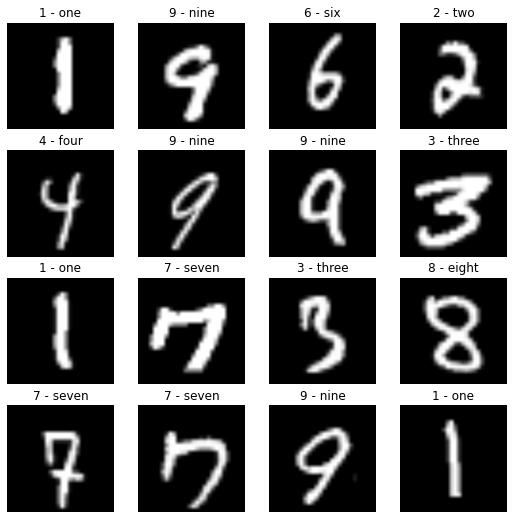

In [8]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")#(c,h,w) moves channel to the back in accordance to the matplotlib format
  plt.title(class_names[label])
  plt.axis(False)

In [9]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 256
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
architecture = 'VGG19'
model_VGG19_0 = VGG_net(in_channels=1, num_classes=10, architecture=architecture).to(device)

In [11]:
def print_train_time(start:float,
                     end:float,
                     device:torch.device=None):
  total_time = end-start
  print(f"Train time on {device} : {total_time:.3f} seconds")
  return total_time

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_VGG19_0.parameters(), lr=0.001)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
#Functionizing training and evaluation/testing loops
#We create a function for training loop - train_step()
#testing loop - test_step()

def train_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  train_loss, train_acc = 0, 0
  #Put model in training mode
  model.train()
  #Add a loop through the training batches 
  for batch, (X,y) in enumerate(data_loader):#Enumerate helps keeping track of batches
    #Put data on target device
    X,y = X.to(device), y.to(device)
    #forward pass
    y_pred = model(X)
    #loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
    #Optimizer zero grad
    optimizer.zero_grad()
    #Loss backward
    loss.backward()
    #Step
    optimizer.step()

  #Adjust the training loss so that it gives us the loss per epoch an not per batch
  #Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f}, Train acc: {train_acc:.2f}%")

In [14]:
def test_step(model:torch.nn.Module, data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.Module,optimizer:torch.optim.Optimizer,accuracy_fn,device:torch.device=device):
  #Performs training step on model trying to learn from data loader
  test_loss, test_acc = 0, 0
  #Put model in training mode
  model.eval()
  #Add a loop through the training batches 
  with torch.inference_mode():
    for X,y in data_loader:#Enumerate helps keeping track of batches
      #Put data on target device
      X,y = X.to(device), y.to(device)
      #forward pass
      test_pred = model(X)
      #loss and accuracy
      loss = loss_fn(test_pred, y)
      test_loss += loss
      test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))

    #Adjust the training loss so that it gives us the loss per epoch an not per batch
    #Divide total train loss by length of train dataloader
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}% , Running on {device}")

In [15]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=20

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_VGG19_0, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_VGG19_0,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 2.24963, Train acc: 18.06%


  5%|▌         | 1/20 [00:31<09:51, 31.11s/it]

Test Loss: 2.29516, Test acc: 12.06% , Running on cuda
Epoch: 1 ----
Train Loss: 2.06557, Train acc: 42.80%


 10%|█         | 2/20 [00:58<08:44, 29.14s/it]

Test Loss: 1.96997, Test acc: 67.94% , Running on cuda
Epoch: 2 ----
Train Loss: 1.79825, Train acc: 64.18%


 15%|█▌        | 3/20 [01:26<08:04, 28.52s/it]

Test Loss: 1.55544, Test acc: 78.25% , Running on cuda
Epoch: 3 ----
Train Loss: 1.48423, Train acc: 75.06%


 20%|██        | 4/20 [01:54<07:31, 28.23s/it]

Test Loss: 1.22945, Test acc: 80.95% , Running on cuda
Epoch: 4 ----
Train Loss: 1.18841, Train acc: 80.37%


 25%|██▌       | 5/20 [02:22<07:01, 28.07s/it]

Test Loss: 1.05224, Test acc: 83.71% , Running on cuda
Epoch: 5 ----
Train Loss: 0.94732, Train acc: 83.98%


 30%|███       | 6/20 [02:50<06:31, 27.97s/it]

Test Loss: 0.76302, Test acc: 83.71% , Running on cuda
Epoch: 6 ----
Train Loss: 0.75834, Train acc: 86.85%


 35%|███▌      | 7/20 [03:17<06:02, 27.91s/it]

Test Loss: 0.60616, Test acc: 88.52% , Running on cuda
Epoch: 7 ----
Train Loss: 0.62584, Train acc: 89.13%


 40%|████      | 8/20 [03:45<05:34, 27.89s/it]

Test Loss: 0.58715, Test acc: 89.13% , Running on cuda
Epoch: 8 ----
Train Loss: 0.52893, Train acc: 90.05%


 45%|████▌     | 9/20 [04:13<05:06, 27.87s/it]

Test Loss: 0.43087, Test acc: 91.02% , Running on cuda
Epoch: 9 ----
Train Loss: 0.44815, Train acc: 91.56%


 50%|█████     | 10/20 [04:41<04:38, 27.85s/it]

Test Loss: 0.38370, Test acc: 92.04% , Running on cuda
Epoch: 10 ----
Train Loss: 0.39172, Train acc: 92.51%


 55%|█████▌    | 11/20 [05:09<04:10, 27.84s/it]

Test Loss: 0.33501, Test acc: 92.44% , Running on cuda
Epoch: 11 ----
Train Loss: 0.35071, Train acc: 93.12%


 60%|██████    | 12/20 [05:36<03:42, 27.85s/it]

Test Loss: 0.30961, Test acc: 92.43% , Running on cuda
Epoch: 12 ----
Train Loss: 0.30787, Train acc: 93.54%


 65%|██████▌   | 13/20 [06:04<03:14, 27.84s/it]

Test Loss: 0.26498, Test acc: 93.91% , Running on cuda
Epoch: 13 ----
Train Loss: 0.27383, Train acc: 94.42%


 70%|███████   | 14/20 [06:32<02:46, 27.82s/it]

Test Loss: 0.24829, Test acc: 94.04% , Running on cuda
Epoch: 14 ----
Train Loss: 0.24884, Train acc: 94.58%


 75%|███████▌  | 15/20 [07:00<02:19, 27.81s/it]

Test Loss: 0.21867, Test acc: 94.36% , Running on cuda
Epoch: 15 ----
Train Loss: 0.22773, Train acc: 95.21%


 80%|████████  | 16/20 [07:28<01:51, 27.81s/it]

Test Loss: 0.20521, Test acc: 94.66% , Running on cuda
Epoch: 16 ----
Train Loss: 0.21184, Train acc: 95.55%


 85%|████████▌ | 17/20 [07:55<01:23, 27.81s/it]

Test Loss: 0.19259, Test acc: 95.12% , Running on cuda
Epoch: 17 ----
Train Loss: 0.19406, Train acc: 96.17%


 90%|█████████ | 18/20 [08:23<00:55, 27.81s/it]

Test Loss: 0.18185, Test acc: 95.36% , Running on cuda
Epoch: 18 ----
Train Loss: 0.18535, Train acc: 95.87%


 95%|█████████▌| 19/20 [08:51<00:27, 27.80s/it]

Test Loss: 0.19273, Test acc: 94.72% , Running on cuda
Epoch: 19 ----
Train Loss: 0.17396, Train acc: 96.23%


100%|██████████| 20/20 [09:19<00:00, 27.97s/it]

Test Loss: 0.16050, Test acc: 95.60% , Running on cuda
Train time on cuda : 559.375 seconds


In [16]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "00_VGG19_MNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [17]:
#Saving the model
torch.save(obj=model_VGG19_0.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/00_VGG19_MNIST.pth


In [18]:
#Loading the model
#Create a new instance of the model and update the parameters
architecture = 'VGG19'
model_VGG19_MNIST = VGG_net(in_channels=1, num_classes=10, architecture=architecture).to(device)
model_VGG19_MNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [19]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device=device):
  loss,acc = 0, 0
  #Returns a dictionary containing the results of the model predicting on data_loader
  model.eval()
  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      X,y = X.to(device), y.to(device)
      #Make predictions
      y_pred = model(X)

      #Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                         y_pred=y_pred.argmax(dim=1))
    #Scale the loss and acc to find the average loss and acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

In [20]:
#Get model results
model_VGG19_MNIST_results = eval_model(
    model=model_VGG19_MNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_VGG19_MNIST_results

100%|██████████| 8/8 [00:02<00:00,  3.28it/s]


{'model_name': 'VGG_net',
 'model_loss': 0.1605025678873062,
 'model_acc': 95.60171274038461}

In [21]:
#FashionMNIST
train_data = datasets.FashionMNIST(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

test_data = datasets.FashionMNIST(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [22]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'],
 {'T-shirt/top': 0,
  'Trouser': 1,
  'Pullover': 2,
  'Dress': 3,
  'Coat': 4,
  'Sandal': 5,
  'Shirt': 6,
  'Sneaker': 7,
  'Bag': 8,
  'Ankle boot': 9})

In [23]:
import torch.utils.data as data_utils

indices_train = torch.arange(1000)
indices_test = torch.arange(200)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(1000, 200)

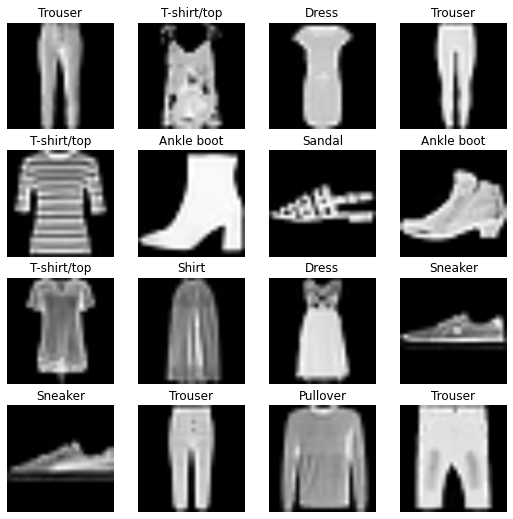

In [24]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [39]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [40]:
architecture = 'VGG19'
model_VGG19_1 = VGG_net(in_channels=1, num_classes=10, architecture=architecture).to(device)

In [41]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_VGG19_1.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [43]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=20

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_VGG19_1, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_VGG19_1,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 1.85571, Train acc: 36.43%


  5%|▌         | 1/20 [00:03<00:59,  3.11s/it]

Test Loss: 3.30156, Test acc: 8.93% , Running on cuda
Epoch: 1 ----
Train Loss: 1.16716, Train acc: 58.50%


 10%|█         | 2/20 [00:06<00:55,  3.10s/it]

Test Loss: 2.44177, Test acc: 37.50% , Running on cuda
Epoch: 2 ----
Train Loss: 0.91225, Train acc: 68.16%


 15%|█▌        | 3/20 [00:09<00:52,  3.09s/it]

Test Loss: 0.86105, Test acc: 66.96% , Running on cuda
Epoch: 3 ----
Train Loss: 0.74451, Train acc: 72.56%


 20%|██        | 4/20 [00:12<00:49,  3.09s/it]

Test Loss: 0.76780, Test acc: 72.77% , Running on cuda
Epoch: 4 ----
Train Loss: 0.59503, Train acc: 77.54%


 25%|██▌       | 5/20 [00:15<00:46,  3.09s/it]

Test Loss: 0.70945, Test acc: 75.89% , Running on cuda
Epoch: 5 ----
Train Loss: 0.50503, Train acc: 81.25%


 30%|███       | 6/20 [00:18<00:43,  3.09s/it]

Test Loss: 1.17167, Test acc: 62.95% , Running on cuda
Epoch: 6 ----
Train Loss: 0.52238, Train acc: 79.98%


 35%|███▌      | 7/20 [00:21<00:40,  3.09s/it]

Test Loss: 1.20362, Test acc: 72.32% , Running on cuda
Epoch: 7 ----
Train Loss: 0.43099, Train acc: 84.38%


 40%|████      | 8/20 [00:24<00:37,  3.09s/it]

Test Loss: 0.83691, Test acc: 69.20% , Running on cuda
Epoch: 8 ----
Train Loss: 0.36802, Train acc: 87.30%


 45%|████▌     | 9/20 [00:27<00:34,  3.09s/it]

Test Loss: 0.97001, Test acc: 77.23% , Running on cuda
Epoch: 9 ----
Train Loss: 0.35137, Train acc: 88.28%


 50%|█████     | 10/20 [00:30<00:30,  3.09s/it]

Test Loss: 0.53313, Test acc: 78.57% , Running on cuda
Epoch: 10 ----
Train Loss: 0.30347, Train acc: 89.55%


 55%|█████▌    | 11/20 [00:34<00:27,  3.09s/it]

Test Loss: 0.53806, Test acc: 83.04% , Running on cuda
Epoch: 11 ----
Train Loss: 0.24769, Train acc: 91.11%


 60%|██████    | 12/20 [00:37<00:24,  3.09s/it]

Test Loss: 1.77521, Test acc: 59.82% , Running on cuda
Epoch: 12 ----
Train Loss: 0.35161, Train acc: 87.30%


 65%|██████▌   | 13/20 [00:40<00:21,  3.09s/it]

Test Loss: 0.71780, Test acc: 75.45% , Running on cuda
Epoch: 13 ----
Train Loss: 0.24159, Train acc: 92.19%


 70%|███████   | 14/20 [00:43<00:18,  3.09s/it]

Test Loss: 0.51805, Test acc: 84.82% , Running on cuda
Epoch: 14 ----
Train Loss: 0.15406, Train acc: 94.04%


 75%|███████▌  | 15/20 [00:46<00:15,  3.10s/it]

Test Loss: 0.68749, Test acc: 81.25% , Running on cuda
Epoch: 15 ----
Train Loss: 0.15974, Train acc: 93.55%


 80%|████████  | 16/20 [00:49<00:12,  3.09s/it]

Test Loss: 0.67792, Test acc: 81.70% , Running on cuda
Epoch: 16 ----
Train Loss: 0.15305, Train acc: 94.14%


 85%|████████▌ | 17/20 [00:52<00:09,  3.09s/it]

Test Loss: 0.65978, Test acc: 83.48% , Running on cuda
Epoch: 17 ----
Train Loss: 0.10014, Train acc: 96.29%


 90%|█████████ | 18/20 [00:55<00:06,  3.09s/it]

Test Loss: 0.97622, Test acc: 75.00% , Running on cuda
Epoch: 18 ----
Train Loss: 0.14540, Train acc: 95.02%


 95%|█████████▌| 19/20 [00:58<00:03,  3.09s/it]

Test Loss: 0.57768, Test acc: 82.59% , Running on cuda
Epoch: 19 ----
Train Loss: 0.09532, Train acc: 96.00%


100%|██████████| 20/20 [01:01<00:00,  3.09s/it]

Test Loss: 0.65767, Test acc: 85.27% , Running on cuda
Train time on cuda : 61.834 seconds


In [44]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "01_VGG19_FashionMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [49]:
#Saving the model
torch.save(obj=model_VGG19_1.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/01_VGG19_FashionMNIST.pth


In [50]:
#Loading the model
#Create a new instance of the model and update the parameters
architecture = 'VGG19'
model_VGG19_FashionMNIST = VGG_net(in_channels=1, num_classes=10, architecture=architecture).to(device)
model_VGG19_FashionMNIST.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [51]:
#Get model results
model_VGG19_FashionMNIST_results = eval_model(
    model=model_VGG19_FashionMNIST,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_VGG19_FashionMNIST_results

100%|██████████| 7/7 [00:00<00:00, 24.03it/s]


{'model_name': 'VGG_net',
 'model_loss': 0.6576703190803528,
 'model_acc': 85.26785714285714}

In [55]:
#CIFAR 10
train_data = datasets.CIFAR10(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

test_data = datasets.CIFAR10(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [56]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 {'airplane': 0,
  'automobile': 1,
  'bird': 2,
  'cat': 3,
  'deer': 4,
  'dog': 5,
  'frog': 6,
  'horse': 7,
  'ship': 8,
  'truck': 9})

In [57]:
import torch.utils.data as data_utils

indices_train = torch.arange(10000)
indices_test = torch.arange(2000)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(10000, 2000)

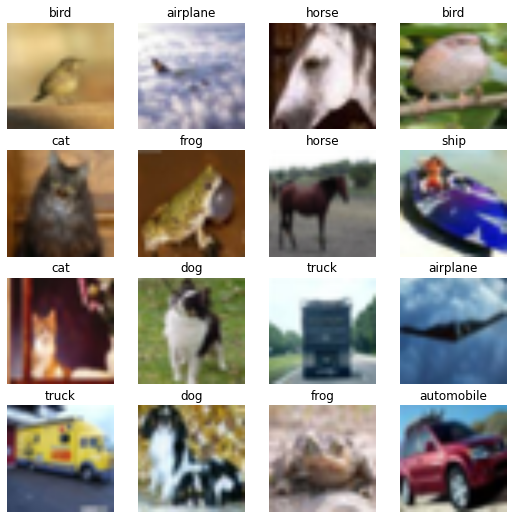

In [58]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1,2,0))
  plt.title(class_names[label])
  plt.axis(False)

In [59]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [60]:
architecture = 'VGG19'
model_VGG19_2 = VGG_net(in_channels=3, num_classes=10, architecture=architecture).to(device)

In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_VGG19_2.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [64]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_VGG19_2, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_VGG19_2,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 1.90105, Train acc: 27.81%


  2%|▏         | 1/50 [00:31<25:25, 31.14s/it]

Test Loss: 1.78966, Test acc: 32.28% , Running on cuda
Epoch: 1 ----
Train Loss: 1.56460, Train acc: 41.22%


  4%|▍         | 2/50 [01:02<24:49, 31.04s/it]

Test Loss: 2.69228, Test acc: 26.81% , Running on cuda
Epoch: 2 ----
Train Loss: 1.38933, Train acc: 48.64%


  6%|▌         | 3/50 [01:33<24:17, 31.00s/it]

Test Loss: 2.23168, Test acc: 32.37% , Running on cuda
Epoch: 3 ----
Train Loss: 1.24581, Train acc: 54.47%


  8%|▊         | 4/50 [02:04<23:45, 30.98s/it]

Test Loss: 1.32630, Test acc: 50.34% , Running on cuda
Epoch: 4 ----
Train Loss: 1.09524, Train acc: 59.87%


 10%|█         | 5/50 [02:34<23:13, 30.98s/it]

Test Loss: 1.82693, Test acc: 38.04% , Running on cuda
Epoch: 5 ----
Train Loss: 0.98158, Train acc: 64.94%


 12%|█▏        | 6/50 [03:05<22:42, 30.97s/it]

Test Loss: 1.40416, Test acc: 50.54% , Running on cuda
Epoch: 6 ----
Train Loss: 0.86740, Train acc: 69.38%


 14%|█▍        | 7/50 [03:36<22:11, 30.97s/it]

Test Loss: 1.65474, Test acc: 50.10% , Running on cuda
Epoch: 7 ----
Train Loss: 0.76375, Train acc: 72.83%


 16%|█▌        | 8/50 [04:07<21:40, 30.96s/it]

Test Loss: 3.20173, Test acc: 42.33% , Running on cuda
Epoch: 8 ----
Train Loss: 0.67991, Train acc: 75.70%


 18%|█▊        | 9/50 [04:38<21:08, 30.95s/it]

Test Loss: 7.08441, Test acc: 23.97% , Running on cuda
Epoch: 9 ----
Train Loss: 0.59640, Train acc: 79.04%


 20%|██        | 10/50 [05:09<20:38, 30.95s/it]

Test Loss: 1.20474, Test acc: 62.79% , Running on cuda
Epoch: 10 ----
Train Loss: 0.49837, Train acc: 82.39%


 22%|██▏       | 11/50 [05:40<20:06, 30.94s/it]

Test Loss: 2.07188, Test acc: 43.95% , Running on cuda
Epoch: 11 ----
Train Loss: 0.46429, Train acc: 83.89%


 24%|██▍       | 12/50 [06:11<19:35, 30.94s/it]

Test Loss: 1.68532, Test acc: 53.37% , Running on cuda
Epoch: 12 ----
Train Loss: 0.39873, Train acc: 85.95%


 26%|██▌       | 13/50 [06:42<19:04, 30.94s/it]

Test Loss: 2.66187, Test acc: 41.65% , Running on cuda
Epoch: 13 ----
Train Loss: 0.34992, Train acc: 87.97%


 28%|██▊       | 14/50 [07:13<18:33, 30.94s/it]

Test Loss: 3.32386, Test acc: 46.53% , Running on cuda
Epoch: 14 ----
Train Loss: 0.28750, Train acc: 89.80%


 30%|███       | 15/50 [07:44<18:02, 30.94s/it]

Test Loss: 6.17526, Test acc: 34.13% , Running on cuda
Epoch: 15 ----
Train Loss: 0.25002, Train acc: 91.17%


 32%|███▏      | 16/50 [08:15<17:31, 30.93s/it]

Test Loss: 1.88954, Test acc: 60.64% , Running on cuda
Epoch: 16 ----
Train Loss: 0.20652, Train acc: 92.72%


 34%|███▍      | 17/50 [08:46<17:00, 30.93s/it]

Test Loss: 1.07237, Test acc: 70.02% , Running on cuda
Epoch: 17 ----
Train Loss: 0.18847, Train acc: 93.39%


 36%|███▌      | 18/50 [09:17<16:29, 30.94s/it]

Test Loss: 1.13674, Test acc: 72.27% , Running on cuda
Epoch: 18 ----
Train Loss: 0.15736, Train acc: 94.59%


 38%|███▊      | 19/50 [09:48<15:59, 30.94s/it]

Test Loss: 1.27576, Test acc: 69.09% , Running on cuda
Epoch: 19 ----
Train Loss: 0.12820, Train acc: 95.83%


 40%|████      | 20/50 [10:19<15:28, 30.94s/it]

Test Loss: 1.24555, Test acc: 70.21% , Running on cuda
Epoch: 20 ----
Train Loss: 0.08238, Train acc: 97.34%


 42%|████▏     | 21/50 [10:50<14:57, 30.94s/it]

Test Loss: 7.28401, Test acc: 30.52% , Running on cuda
Epoch: 21 ----
Train Loss: 0.17027, Train acc: 94.48%


 44%|████▍     | 22/50 [11:20<14:26, 30.94s/it]

Test Loss: 1.40011, Test acc: 65.97% , Running on cuda
Epoch: 22 ----
Train Loss: 0.08315, Train acc: 97.38%


 46%|████▌     | 23/50 [11:51<13:55, 30.95s/it]

Test Loss: 1.61175, Test acc: 67.82% , Running on cuda
Epoch: 23 ----
Train Loss: 0.09809, Train acc: 96.72%


 48%|████▊     | 24/50 [12:22<13:24, 30.95s/it]

Test Loss: 3.86379, Test acc: 51.66% , Running on cuda
Epoch: 24 ----
Train Loss: 0.11429, Train acc: 96.43%


 50%|█████     | 25/50 [12:53<12:53, 30.96s/it]

Test Loss: 1.24552, Test acc: 73.58% , Running on cuda
Epoch: 25 ----
Train Loss: 0.03941, Train acc: 98.64%


 52%|█████▏    | 26/50 [13:24<12:22, 30.95s/it]

Test Loss: 1.23700, Test acc: 76.22% , Running on cuda
Epoch: 26 ----
Train Loss: 0.05883, Train acc: 98.09%


 54%|█████▍    | 27/50 [13:55<11:51, 30.94s/it]

Test Loss: 11.01684, Test acc: 38.87% , Running on cuda
Epoch: 27 ----
Train Loss: 0.09235, Train acc: 97.33%


 56%|█████▌    | 28/50 [14:26<11:20, 30.94s/it]

Test Loss: 45.99898, Test acc: 11.96% , Running on cuda
Epoch: 28 ----
Train Loss: 0.11834, Train acc: 96.81%


 58%|█████▊    | 29/50 [14:57<10:49, 30.95s/it]

Test Loss: 1.13116, Test acc: 75.78% , Running on cuda
Epoch: 29 ----
Train Loss: 0.04399, Train acc: 98.52%


 60%|██████    | 30/50 [15:28<10:18, 30.95s/it]

Test Loss: 1.19989, Test acc: 76.90% , Running on cuda
Epoch: 30 ----
Train Loss: 0.02725, Train acc: 99.06%


 62%|██████▏   | 31/50 [15:59<09:48, 30.95s/it]

Test Loss: 4.68894, Test acc: 54.30% , Running on cuda
Epoch: 31 ----
Train Loss: 0.07116, Train acc: 97.66%


 64%|██████▍   | 32/50 [16:30<09:16, 30.94s/it]

Test Loss: 1.54125, Test acc: 73.63% , Running on cuda
Epoch: 32 ----
Train Loss: 0.02963, Train acc: 99.08%


 66%|██████▌   | 33/50 [17:01<08:45, 30.93s/it]

Test Loss: 1.21458, Test acc: 77.44% , Running on cuda
Epoch: 33 ----
Train Loss: 0.01857, Train acc: 99.34%


 68%|██████▊   | 34/50 [17:32<08:15, 30.94s/it]

Test Loss: 1.27073, Test acc: 76.71% , Running on cuda
Epoch: 34 ----
Train Loss: 0.02722, Train acc: 99.11%


 70%|███████   | 35/50 [18:03<07:44, 30.94s/it]

Test Loss: 1.95864, Test acc: 71.14% , Running on cuda
Epoch: 35 ----
Train Loss: 0.03150, Train acc: 99.04%


 72%|███████▏  | 36/50 [18:34<07:13, 30.94s/it]

Test Loss: 2.98174, Test acc: 61.52% , Running on cuda
Epoch: 36 ----
Train Loss: 0.05438, Train acc: 98.46%


 74%|███████▍  | 37/50 [19:05<06:42, 30.94s/it]

Test Loss: 1.12239, Test acc: 78.32% , Running on cuda
Epoch: 37 ----
Train Loss: 0.01672, Train acc: 99.55%


 76%|███████▌  | 38/50 [19:36<06:11, 30.94s/it]

Test Loss: 1.43219, Test acc: 72.36% , Running on cuda
Epoch: 38 ----
Train Loss: 0.03615, Train acc: 98.80%


 78%|███████▊  | 39/50 [20:06<05:40, 30.93s/it]

Test Loss: 1.16684, Test acc: 76.27% , Running on cuda
Epoch: 39 ----
Train Loss: 0.01980, Train acc: 99.36%


 80%|████████  | 40/50 [20:37<05:09, 30.93s/it]

Test Loss: 1.18512, Test acc: 78.37% , Running on cuda
Epoch: 40 ----
Train Loss: 0.00492, Train acc: 99.88%


 82%|████████▏ | 41/50 [21:08<04:38, 30.93s/it]

Test Loss: 1.24048, Test acc: 78.56% , Running on cuda
Epoch: 41 ----
Train Loss: 0.00213, Train acc: 99.96%


 84%|████████▍ | 42/50 [21:39<04:07, 30.94s/it]

Test Loss: 1.35195, Test acc: 78.52% , Running on cuda
Epoch: 42 ----
Train Loss: 0.00234, Train acc: 99.92%


 86%|████████▌ | 43/50 [22:10<03:36, 30.93s/it]

Test Loss: 1.29111, Test acc: 78.47% , Running on cuda
Epoch: 43 ----
Train Loss: 0.00148, Train acc: 99.97%


 88%|████████▊ | 44/50 [22:41<03:05, 30.94s/it]

Test Loss: 1.27891, Test acc: 78.71% , Running on cuda
Epoch: 44 ----
Train Loss: 0.00203, Train acc: 99.90%


 90%|█████████ | 45/50 [23:12<02:34, 30.94s/it]

Test Loss: 1.34768, Test acc: 79.20% , Running on cuda
Epoch: 45 ----
Train Loss: 0.00900, Train acc: 99.74%


 92%|█████████▏| 46/50 [23:43<02:03, 30.93s/it]

Test Loss: 1.60402, Test acc: 75.44% , Running on cuda
Epoch: 46 ----
Train Loss: 0.00688, Train acc: 99.78%


 94%|█████████▍| 47/50 [24:14<01:32, 30.94s/it]

Test Loss: 1.35620, Test acc: 78.22% , Running on cuda
Epoch: 47 ----
Train Loss: 0.01814, Train acc: 99.47%


 96%|█████████▌| 48/50 [24:45<01:01, 30.93s/it]

Test Loss: 1.46742, Test acc: 76.22% , Running on cuda
Epoch: 48 ----
Train Loss: 0.04015, Train acc: 98.75%


 98%|█████████▊| 49/50 [25:16<00:30, 30.92s/it]

Test Loss: 1.56468, Test acc: 74.02% , Running on cuda
Epoch: 49 ----
Train Loss: 0.02552, Train acc: 99.22%


100%|██████████| 50/50 [25:47<00:00, 30.94s/it]

Test Loss: 3.20174, Test acc: 52.98% , Running on cuda
Train time on cuda : 1547.242 seconds


In [65]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "02_VGG19_CIFAR10.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [66]:
#Saving the model
torch.save(obj=model_VGG19_2.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/02_VGG19_CIFAR10.pth


In [67]:
#Loading the model
#Create a new instance of the model and update the parameters
architecture = 'VGG19'
model_VGG19_CIFAR10 = VGG_net(in_channels=3, num_classes=10, architecture=architecture).to(device)
model_VGG19_CIFAR10.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [68]:
#Get model results
model_VGG19_CIFAR10_results = eval_model(
    model=model_VGG19_CIFAR10,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_VGG19_CIFAR10_results

100%|██████████| 32/32 [00:03<00:00,  8.32it/s]


{'model_name': 'VGG_net',
 'model_loss': 3.2017366886138916,
 'model_acc': 52.978515625}

In [94]:
#CIFAR100
train_data = datasets.CIFAR100(root="data",
                                   train=True,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

test_data = datasets.CIFAR100(root="data",
                                   train=False,
                                   download=True,
                                   transform=transforms.Compose([transforms.Resize(size=(224,224)),transforms.ToTensor()]))

Files already downloaded and verified
Files already downloaded and verified


In [95]:
class_names = train_data.classes
class_to_idx = train_data.class_to_idx
class_names, class_to_idx

(['apple',
  'aquarium_fish',
  'baby',
  'bear',
  'beaver',
  'bed',
  'bee',
  'beetle',
  'bicycle',
  'bottle',
  'bowl',
  'boy',
  'bridge',
  'bus',
  'butterfly',
  'camel',
  'can',
  'castle',
  'caterpillar',
  'cattle',
  'chair',
  'chimpanzee',
  'clock',
  'cloud',
  'cockroach',
  'couch',
  'crab',
  'crocodile',
  'cup',
  'dinosaur',
  'dolphin',
  'elephant',
  'flatfish',
  'forest',
  'fox',
  'girl',
  'hamster',
  'house',
  'kangaroo',
  'keyboard',
  'lamp',
  'lawn_mower',
  'leopard',
  'lion',
  'lizard',
  'lobster',
  'man',
  'maple_tree',
  'motorcycle',
  'mountain',
  'mouse',
  'mushroom',
  'oak_tree',
  'orange',
  'orchid',
  'otter',
  'palm_tree',
  'pear',
  'pickup_truck',
  'pine_tree',
  'plain',
  'plate',
  'poppy',
  'porcupine',
  'possum',
  'rabbit',
  'raccoon',
  'ray',
  'road',
  'rocket',
  'rose',
  'sea',
  'seal',
  'shark',
  'shrew',
  'skunk',
  'skyscraper',
  'snail',
  'snake',
  'spider',
  'squirrel',
  'streetcar',
  

In [96]:
import torch.utils.data as data_utils

indices_train = torch.arange(10000)
indices_test = torch.arange(200)
train_data = data_utils.Subset(train_data, indices_train)
test_data = data_utils.Subset(test_data, indices_test)
len(train_data), len(test_data)

(10000, 200)

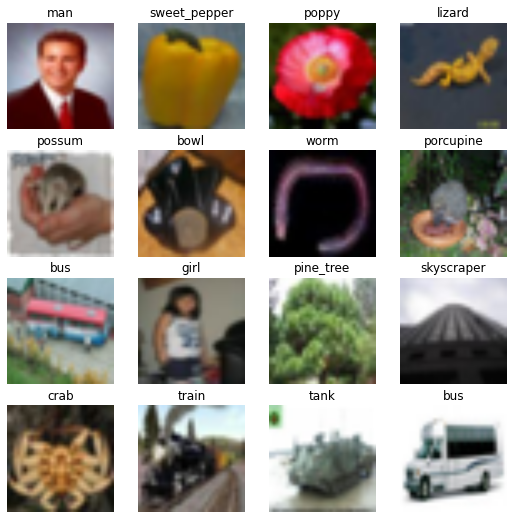

In [97]:
#Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.permute(1,2,0))
  plt.title(class_names[label])
  plt.axis(False)

In [98]:
#Prepare Dataloader that prepares our data into python iterable
#We turn our data into mini batches since it is more computationally efficient
from torch.utils.data import DataLoader

#Setup the batch size hyperparameter
BATCH_SIZE = 32
device = "cuda" if torch.cuda.is_available() else "cpu"

#Turn datasets into iterables(batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [99]:
architecture = 'VGG19'
model_VGG19_3 = VGG_net(in_channels=3, num_classes=100, architecture=architecture).to(device)

In [100]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_VGG19_3.parameters(), lr=0.03)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [101]:
torch.manual_seed(42)

#Measure time
train_time_start_on_gpu = timer()

#Set epochs
epochs=50

#Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch} ----")
  train_step(model=model_VGG19_3, data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
  test_step(model=model_VGG19_3,data_loader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device=device)
  
train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0 ----
Train Loss: 4.41560, Train acc: 2.92%


  2%|▏         | 1/50 [00:29<24:02, 29.43s/it]

Test Loss: 4.22207, Test acc: 6.25% , Running on cuda
Epoch: 1 ----
Train Loss: 4.10969, Train acc: 5.81%


  4%|▍         | 2/50 [00:58<23:29, 29.37s/it]

Test Loss: 4.20914, Test acc: 2.68% , Running on cuda
Epoch: 2 ----
Train Loss: 3.94318, Train acc: 7.83%


  6%|▌         | 3/50 [01:28<22:58, 29.33s/it]

Test Loss: 4.22709, Test acc: 8.48% , Running on cuda
Epoch: 3 ----
Train Loss: 3.79193, Train acc: 10.43%


  8%|▊         | 4/50 [01:57<22:27, 29.30s/it]

Test Loss: 3.66695, Test acc: 8.93% , Running on cuda
Epoch: 4 ----
Train Loss: 3.63616, Train acc: 13.90%


 10%|█         | 5/50 [02:26<21:57, 29.28s/it]

Test Loss: 3.52088, Test acc: 15.62% , Running on cuda
Epoch: 5 ----
Train Loss: 3.47930, Train acc: 16.18%


 12%|█▏        | 6/50 [02:55<21:27, 29.26s/it]

Test Loss: 3.43092, Test acc: 19.20% , Running on cuda
Epoch: 6 ----
Train Loss: 3.32850, Train acc: 19.04%


 14%|█▍        | 7/50 [03:25<20:58, 29.26s/it]

Test Loss: 3.12170, Test acc: 23.21% , Running on cuda
Epoch: 7 ----
Train Loss: 3.17842, Train acc: 21.73%


 16%|█▌        | 8/50 [03:54<20:28, 29.26s/it]

Test Loss: 3.18690, Test acc: 23.66% , Running on cuda
Epoch: 8 ----
Train Loss: 3.00910, Train acc: 24.70%


 18%|█▊        | 9/50 [04:23<19:59, 29.26s/it]

Test Loss: 3.13474, Test acc: 24.55% , Running on cuda
Epoch: 9 ----
Train Loss: 2.84771, Train acc: 27.19%


 20%|██        | 10/50 [04:52<19:30, 29.25s/it]

Test Loss: 2.88941, Test acc: 34.38% , Running on cuda
Epoch: 10 ----
Train Loss: 2.71462, Train acc: 29.88%


 22%|██▏       | 11/50 [05:22<19:00, 29.25s/it]

Test Loss: 3.16631, Test acc: 25.00% , Running on cuda
Epoch: 11 ----
Train Loss: 2.51895, Train acc: 34.36%


 24%|██▍       | 12/50 [05:51<18:31, 29.25s/it]

Test Loss: 2.84220, Test acc: 33.93% , Running on cuda
Epoch: 12 ----
Train Loss: 2.35563, Train acc: 37.89%


 26%|██▌       | 13/50 [06:20<18:02, 29.25s/it]

Test Loss: 2.83363, Test acc: 31.25% , Running on cuda
Epoch: 13 ----
Train Loss: 2.17313, Train acc: 41.19%


 28%|██▊       | 14/50 [06:49<17:32, 29.25s/it]

Test Loss: 2.84904, Test acc: 33.04% , Running on cuda
Epoch: 14 ----
Train Loss: 1.99965, Train acc: 45.24%


 30%|███       | 15/50 [07:19<17:03, 29.25s/it]

Test Loss: 3.16144, Test acc: 34.82% , Running on cuda
Epoch: 15 ----
Train Loss: 1.83481, Train acc: 49.23%


 32%|███▏      | 16/50 [07:48<16:34, 29.24s/it]

Test Loss: 2.61693, Test acc: 37.95% , Running on cuda
Epoch: 16 ----
Train Loss: 1.67046, Train acc: 53.14%


 34%|███▍      | 17/50 [08:17<16:05, 29.25s/it]

Test Loss: 2.88845, Test acc: 37.95% , Running on cuda
Epoch: 17 ----
Train Loss: 1.48906, Train acc: 57.57%


 36%|███▌      | 18/50 [08:46<15:35, 29.24s/it]

Test Loss: 2.98878, Test acc: 33.48% , Running on cuda
Epoch: 18 ----
Train Loss: 1.28785, Train acc: 62.63%


 38%|███▊      | 19/50 [09:16<15:06, 29.25s/it]

Test Loss: 2.84607, Test acc: 38.39% , Running on cuda
Epoch: 19 ----
Train Loss: 1.15657, Train acc: 65.85%


 40%|████      | 20/50 [09:45<14:37, 29.25s/it]

Test Loss: 3.31362, Test acc: 32.59% , Running on cuda
Epoch: 20 ----
Train Loss: 1.01749, Train acc: 69.72%


 42%|████▏     | 21/50 [10:14<14:08, 29.24s/it]

Test Loss: 3.37062, Test acc: 40.18% , Running on cuda
Epoch: 21 ----
Train Loss: 0.85826, Train acc: 74.28%


 44%|████▍     | 22/50 [10:43<13:38, 29.25s/it]

Test Loss: 3.18214, Test acc: 41.52% , Running on cuda
Epoch: 22 ----
Train Loss: 0.75665, Train acc: 76.99%


 46%|████▌     | 23/50 [11:12<13:09, 29.24s/it]

Test Loss: 2.94254, Test acc: 38.39% , Running on cuda
Epoch: 23 ----
Train Loss: 0.65661, Train acc: 79.99%


 48%|████▊     | 24/50 [11:42<12:40, 29.24s/it]

Test Loss: 2.91822, Test acc: 42.41% , Running on cuda
Epoch: 24 ----
Train Loss: 0.57250, Train acc: 82.55%


 50%|█████     | 25/50 [12:11<12:10, 29.24s/it]

Test Loss: 3.30226, Test acc: 40.62% , Running on cuda
Epoch: 25 ----
Train Loss: 0.48432, Train acc: 84.81%


 52%|█████▏    | 26/50 [12:40<11:41, 29.24s/it]

Test Loss: 3.36742, Test acc: 43.30% , Running on cuda
Epoch: 26 ----
Train Loss: 0.42739, Train acc: 86.66%


 54%|█████▍    | 27/50 [13:09<11:12, 29.24s/it]

Test Loss: 3.00592, Test acc: 41.52% , Running on cuda
Epoch: 27 ----
Train Loss: 0.37120, Train acc: 88.54%


 56%|█████▌    | 28/50 [13:39<10:43, 29.24s/it]

Test Loss: 3.30494, Test acc: 45.09% , Running on cuda
Epoch: 28 ----
Train Loss: 0.33083, Train acc: 89.60%


 58%|█████▊    | 29/50 [14:08<10:14, 29.24s/it]

Test Loss: 3.37900, Test acc: 43.30% , Running on cuda
Epoch: 29 ----
Train Loss: 0.30442, Train acc: 90.75%


 60%|██████    | 30/50 [14:37<09:44, 29.24s/it]

Test Loss: 3.17623, Test acc: 49.11% , Running on cuda
Epoch: 30 ----
Train Loss: 0.27534, Train acc: 91.59%


 62%|██████▏   | 31/50 [15:06<09:15, 29.24s/it]

Test Loss: 3.12072, Test acc: 46.88% , Running on cuda
Epoch: 31 ----
Train Loss: 0.24736, Train acc: 92.37%


 64%|██████▍   | 32/50 [15:36<08:46, 29.23s/it]

Test Loss: 2.96872, Test acc: 46.88% , Running on cuda
Epoch: 32 ----
Train Loss: 0.21766, Train acc: 93.15%


 66%|██████▌   | 33/50 [16:05<08:17, 29.26s/it]

Test Loss: 3.38004, Test acc: 42.86% , Running on cuda
Epoch: 33 ----
Train Loss: 0.19675, Train acc: 93.83%


 68%|██████▊   | 34/50 [16:34<07:48, 29.27s/it]

Test Loss: 3.30948, Test acc: 43.30% , Running on cuda
Epoch: 34 ----
Train Loss: 0.18802, Train acc: 93.78%


 70%|███████   | 35/50 [17:03<07:19, 29.27s/it]

Test Loss: 3.75089, Test acc: 37.50% , Running on cuda
Epoch: 35 ----
Train Loss: 0.18089, Train acc: 94.29%


 72%|███████▏  | 36/50 [17:33<06:49, 29.26s/it]

Test Loss: 3.36509, Test acc: 42.86% , Running on cuda
Epoch: 36 ----
Train Loss: 0.17090, Train acc: 94.45%


 74%|███████▍  | 37/50 [18:02<06:20, 29.26s/it]

Test Loss: 3.74955, Test acc: 45.54% , Running on cuda
Epoch: 37 ----
Train Loss: 0.17594, Train acc: 94.66%


 76%|███████▌  | 38/50 [18:31<05:51, 29.26s/it]

Test Loss: 3.41289, Test acc: 46.43% , Running on cuda
Epoch: 38 ----
Train Loss: 0.14176, Train acc: 95.45%


 78%|███████▊  | 39/50 [19:00<05:21, 29.26s/it]

Test Loss: 3.26963, Test acc: 46.43% , Running on cuda
Epoch: 39 ----
Train Loss: 0.13067, Train acc: 95.78%


 80%|████████  | 40/50 [19:30<04:52, 29.26s/it]

Test Loss: 3.58409, Test acc: 44.20% , Running on cuda
Epoch: 40 ----
Train Loss: 0.10091, Train acc: 96.81%


 82%|████████▏ | 41/50 [19:59<04:23, 29.25s/it]

Test Loss: 3.59805, Test acc: 45.54% , Running on cuda
Epoch: 41 ----
Train Loss: 0.09803, Train acc: 96.88%


 84%|████████▍ | 42/50 [20:28<03:54, 29.26s/it]

Test Loss: 3.61962, Test acc: 47.32% , Running on cuda
Epoch: 42 ----
Train Loss: 0.13795, Train acc: 95.50%


 86%|████████▌ | 43/50 [20:58<03:24, 29.26s/it]

Test Loss: 3.41270, Test acc: 46.88% , Running on cuda
Epoch: 43 ----
Train Loss: 0.10313, Train acc: 96.76%


 88%|████████▊ | 44/50 [21:27<02:55, 29.26s/it]

Test Loss: 3.41229, Test acc: 46.43% , Running on cuda
Epoch: 44 ----
Train Loss: 0.09661, Train acc: 96.85%


 90%|█████████ | 45/50 [21:56<02:26, 29.26s/it]

Test Loss: 3.97432, Test acc: 45.98% , Running on cuda
Epoch: 45 ----
Train Loss: 0.09002, Train acc: 97.22%


 92%|█████████▏| 46/50 [22:25<01:57, 29.26s/it]

Test Loss: 3.87877, Test acc: 43.30% , Running on cuda
Epoch: 46 ----
Train Loss: 0.08506, Train acc: 97.26%


 94%|█████████▍| 47/50 [22:55<01:27, 29.26s/it]

Test Loss: 3.47972, Test acc: 43.75% , Running on cuda
Epoch: 47 ----
Train Loss: 0.08462, Train acc: 97.45%


 96%|█████████▌| 48/50 [23:24<00:58, 29.26s/it]

Test Loss: 3.48071, Test acc: 41.96% , Running on cuda
Epoch: 48 ----
Train Loss: 0.08292, Train acc: 97.33%


 98%|█████████▊| 49/50 [23:53<00:29, 29.26s/it]

Test Loss: 3.68012, Test acc: 43.30% , Running on cuda
Epoch: 49 ----
Train Loss: 0.07100, Train acc: 97.60%


100%|██████████| 50/50 [24:22<00:00, 29.26s/it]

Test Loss: 3.75134, Test acc: 47.32% , Running on cuda
Train time on cuda : 1462.826 seconds


In [102]:
#Now we save the model
from pathlib import Path
#Create the model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
#Create the model save path
MODEL_NAME = "03_VGG19_CIFAR100.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

In [103]:
#Saving the model
torch.save(obj=model_VGG19_3.state_dict(),
           f=MODEL_SAVE_PATH)
print(f'Saved at {MODEL_SAVE_PATH}')

Saved at models/03_VGG19_CIFAR100.pth


In [92]:
#Loading the model
#Create a new instance of the model and update the parameters
architecture = 'VGG19'
model_VGG19_CIFAR100 = VGG_net(in_channels=3, num_classes=100, architecture=architecture).to(device)
model_VGG19_CIFAR100.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [93]:
#Get model results
model_VGG19_CIFAR100_results = eval_model(
    model=model_VGG19_CIFAR100,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device
)
model_VGG19_CIFAR100_results

100%|██████████| 63/63 [00:03<00:00, 16.31it/s]


{'model_name': 'VGG_net',
 'model_loss': 3.767873525619507,
 'model_acc': 37.15277777777778}